<a href="https://colab.research.google.com/github/mohsenfayyaz/NLP_Assignments/blob/master/Digikala_Comments_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
SENTENCE_MAX_LEN = 70

In [23]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/datasets/Digikal_Data.csv')
print(data.shape)
data.head()

(3261, 3)


,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [24]:
def filter_digikala_data(df):
    new_df = df.drop(["Score"], axis=1)
    new_df = new_df[(new_df["Suggestion"] == 1) | (new_df["Suggestion"] == 2)]
    return new_df

In [25]:
def embed_words(df):
    corpus = df.Text.values
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(corpus)

    vocab_size = len(tokenizer.word_index) + 1
    print("Vocab Size:", vocab_size)

    print("Text:", corpus[0])
    encoded_docs = tokenizer.texts_to_sequences(corpus)  # Change words to numbers
    print("embedded:", encoded_docs[0])
    padded_sequence = pad_sequences(encoded_docs, maxlen=SENTENCE_MAX_LEN, padding="post")  # padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.
    print("padded: ", padded_sequence[0])
    print(padded_sequence.shape)
    new_df = df.copy()
    new_df["Text"] = list(padded_sequence)
    return new_df, vocab_size, padded_sequence

In [26]:
def partition_data(df, test_percent=0.2, validation_percent=0.1, shuffle=True):
    df = df[df["Text"].notna()]
    if shuffle:
        df = df.sample(frac=1)
    test, validate, train = np.split(df, [int(test_percent*len(df)), int((test_percent+validation_percent)*len(df))])
    return train, validate, test

In [27]:
from sklearn.utils import resample
def balance_data(df, target_col, majority_value, minority_col):
    df_majority = df[df[target_col]==majority_value]
    df_minority = df[df[target_col]==minority_col]
    
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(df_majority.index),    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    # df_upsampled.Suggestion.value_counts()

    return df_upsampled

Vocab Size: 11218
Text: این اولین تجربه من برای خرید ایفون هست   امروز ب دستم رسیده   به اسم طلایی هست ولی دراصل رزگلده  خیلی هم خوش رنگ هست  
embedded: [4, 415, 434, 10, 12, 50, 3203, 16, 261, 283, 158, 706, 5, 1208, 2120, 16, 15, 11, 9, 328, 124, 16]
padded:  [   4  415  434   10   12   50 3203   16  261  283  158  706    5 1208
 2120   16   15   11    9  328  124   16    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
(2801, 70)


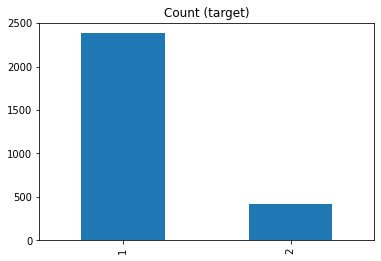

419


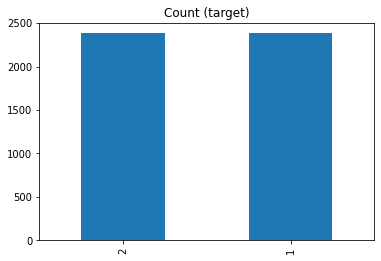

In [28]:
filtered_data = filter_digikala_data(data)
filtered_data, vocab_size, padded_sequence = embed_words(filtered_data)
filtered_data.head()
filtered_data.Suggestion.value_counts().plot(kind='bar', title='Count (target)');
plt.show()
print(filtered_data.Suggestion.value_counts()[2])
filtered_data = balance_data(filtered_data, "Suggestion", 1, 2)
filtered_data.Suggestion.value_counts().plot(kind='bar', title='Count (target)');

In [29]:
train_data, validation_data, test_data = partition_data(filtered_data, test_percent=0.2, validation_percent=0.01, shuffle=True)
print("train:     ", train_data.shape)
print("validation:", validation_data.shape)
print("test:      ", test_data.shape)
train_data.head()

train:      (3764, 2)
validation: (48, 2)
test:       (952, 2)


,Text,Suggestion
416,"[10, 4, 44, 51, 6, 273, 113, 75, 163, 1612, 13...",2
3226,"[984, 8, 2297, 18, 11, 22, 26, 60, 20, 84, 702...",1
1598,"[27, 98, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
60,"[10, 72, 123, 26, 178, 3, 479, 280, 268, 53, 1...",2
172,"[10, 209, 24, 44, 51, 370, 108, 83, 85, 90, 11...",2


**Data is Ready**

**Build Model**

In [30]:
# Build the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

model = Sequential()

embedding_vector_length = 32
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_vector_length, input_length=SENTENCE_MAX_LEN))

model.add(SpatialDropout1D(0.25))

model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 32)            358976    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 375,627
Trainable params: 375,627
Non-trainable params: 0
_________________________________________________________________
None


**Train Model**

In [31]:
tf_train_x = np.asarray(train_data["Text"].to_numpy().tolist())
tf_train_y = train_data["Suggestion"].factorize()[0]
print(tf_train_x.shape)
print(tf_train_x[0])
print(tf_train_y.shape)
print(tf_train_y[0])
history = model.fit(tf_train_x, tf_train_y, validation_split=0.2, epochs=20, batch_size=32)
# np.asarray(train_data["Text"])
# train_data["Text"].values

(3764, 70)
[  10    4   44   51    6  273  113   75  163 1612   13    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
(3764,)
0
Epoch 1/20
95/95 [==============================] - 8s 88ms/step - loss: 0.6930 - accuracy: 0.5048 - val_loss: 0.6928 - val_accuracy: 0.4728
Epoch 2/20
95/95 [==============================] - 8s 85ms/step - loss: 0.6807 - accuracy: 0.5726 - val_loss: 0.6430 - val_accuracy: 0.6149
Epoch 3/20
95/95 [==============================] - 8s 84ms/step - loss: 0.5811 - accuracy: 0.6682 - val_loss: 0.5123 - val_accuracy: 0.7556
Epoch 4/20
95/95 [==============================] - 8s 85ms/step - loss: 0.4374 - accuracy: 0.8017 - val_loss: 0.3986 - val_accuracy: 0.8300
Epoch 5/20
95/95 [==============================] - 8s 85ms

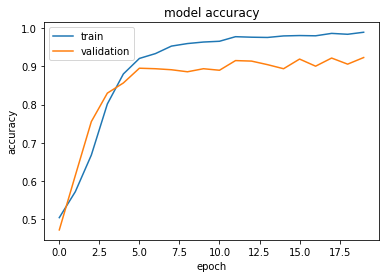

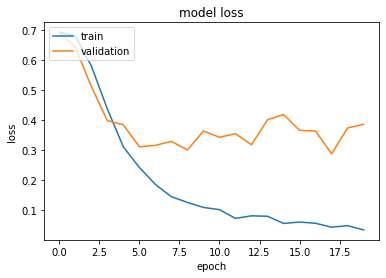

In [32]:
import matplotlib.pyplot as plt
print(history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Testing Model**

In [34]:
tf_test_x = np.asarray(test_data["Text"].to_numpy().tolist())
tf_test_y = test_data["Suggestion"].factorize()[0]
print(tf_test_x.shape)
print(tf_test_y.shape)
print(tf_test_x[5], tf_test_y[5])

# print(model.predict(tf_test_x[0]))
# for x in tf_test_x:
#     print(np.average(model.predict(x)))


print("Evaluating...")
model.evaluate(tf_test_x, tf_test_y)

(952, 70)
(952,)
[   4   44   51    6  795    3  119  240   37  113   11   38 1513    9
  515   13    1    9  679    1    5  154 3433  134    3    4 1852   62
   59   43   32 2211  541    1   59  354  607 1780   55    5   90   11
   38  210  943   16   15   14    1  763   41   13    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0] 1
Evaluating...
30/30 [==============================] - 0s 10ms/step - loss: 0.4973 - accuracy: 0.9086


[0.4972725808620453, 0.9086134433746338]